<a href="https://colab.research.google.com/github/kmadden9/ECGR6119_Midterm/blob/main/Copy_of_Synthetic_bags_Yolo_V5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cloning YOLO github
!git clone https://github.com/ultralytics/yolov5
!pip install -r yolov5/requirements.txt
!pip install utils
!pip install pylabel > /dev/null

Cloning into 'yolov5'...
remote: Enumerating objects: 14184, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 14184 (delta 76), reused 91 (delta 58), pack-reused 14060
Receiving objects: 100% (14184/14184), 13.55 MiB | 32.72 MiB/s, done.
Resolving deltas: 100% (9739/9739), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 4.4 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 1.6 MB 76.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import os 
import random
import shutil
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import logging
import os 
import zipfile
import yaml
import PIL

from IPython.display import Image  # for displaying images
from sklearn.model_selection import train_test_split
from pylabel import importer
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw

logging.getLogger().setLevel(logging.CRITICAL)
random.seed(42)

In [3]:
from pylabel import importer

In [4]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [5]:
!kaggle datasets download -d vencerlanz09/plastic-paper-garbage-bag-synthetic-images

 95% 429M/451M [00:02<00:00, 197MB/s]
100% 451M/451M [00:02<00:00, 178MB/s]


In [6]:
!unzip /content/plastic-paper-garbage-bag-synthetic-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010001.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010002.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010003.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010004.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010005.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010006.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010007.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010008.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010009.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010010.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010011.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010012.jpg  
 

In [ ]:
# Copy images_raw to working directory
# Note: This may take some time depending on the size of your images_raw folder
#!cp -r ../input/plastic-paper-garbage-bag-synthetic-images/ImageClassesCombinedWithCOCOAnnotations/images_raw ./

cp: cannot stat '../input/plastic-paper-garbage-bag-synthetic-images/ImageClassesCombinedWithCOCOAnnotations/images_raw': No such file or directory


In [7]:
#Specify path to the coco.json file
path_to_annotations = r"/content/ImageClassesCombinedWithCOCOAnnotations/coco_instances.json"
#Specify the path to the images (if they are in a different folder than the annotations)
path_to_images = r"/content/ImageClassesCombinedWithCOCOAnnotations/images_raw"

#Import the dataset into the pylable schema 
dataset = importer.ImportCoco(path_to_annotations, path_to_images=path_to_images, name="BCCD_coco")
dataset.df.head(5)

img_folder  img_filename img_path  \
id                                                                             
0   /content/ImageClassesCombinedWithCOCOAnnotatio...  00000000.jpg            
1   /content/ImageClassesCombinedWithCOCOAnnotatio...  00000001.jpg            
2   /content/ImageClassesCombinedWithCOCOAnnotatio...  00000001.jpg            
3   /content/ImageClassesCombinedWithCOCOAnnotatio...  00000001.jpg            
4   /content/ImageClassesCombinedWithCOCOAnnotatio...  00000002.jpg            

    img_id  img_width  img_height img_depth ann_segmented  ann_bbox_xmin  \
id                                                                         
0        0        300         300                                  114.5   
1        1        300         300                                   11.5   
2        1        300         300                                  101.5   
3        1        300         300                                   52.5   
4        2        300         300                                   94.5   

    ann_bbox_ymin  ...                                   ann_segmentation  \
id                 ...                                                      
0           128.5  ...  [[158.0, 275.5, 153.0, 274.5, 135.5, 257.0, 13...   
1           195.5  ...  [[30.0, 292.5, 24.0, 292.5, 21.5, 290.0, 16.5,...   
2            65.5  ...  [[184.0, 272.5, 180.5, 271.0, 174.5, 260.0, 15...   
3           119.5  ...  [[123.0, 193.5, 111.0, 193.5, 105.0, 189.5, 10...   
4            18.5  ...  [[166.0, 191.5, 159.0, 187.5, 154.5, 182.0, 16...   

    ann_iscrowd  ann_pose  ann_truncated  ann_difficult cat_id  cat_name  \
id                                                                         
0             0                                              3   plastic   
1             0                                              3   plastic   
2             0                                              3   plastic   
3             0                                              3   plastic   
4             0                                              3   plastic   

   cat_supercategory split annotated  
id                                    
0               Bags               1  
1               Bags               1  
2               Bags               1  
3               Bags               1  
4               Bags               1  

[5 rows x 25 columns]

In [8]:
print(f"Number of images: {dataset.analyze.num_images}")
print(f"Number of classes: {dataset.analyze.num_classes}")
print(f"Classes:{dataset.analyze.classes}")
print(f"Class counts:\n{dataset.analyze.class_counts}")
print(f"Path to annotations:\n{dataset.path_to_annotations}")

Number of images: 15000
Number of classes: 3
Classes:['garbage', 'paper', 'plastic']
Class counts:
garbage    10062
paper       9967
plastic     9903
Name: cat_name, dtype: int64
Path to annotations:
/content/ImageClassesCombinedWithCOCOAnnotations


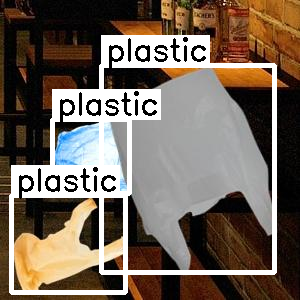

In [9]:
try:
    display(dataset.visualize.ShowBoundingBoxes(1))
    display(dataset.visualize.ShowBoundingBoxes("./images_raw/00000004.jpg"))
except:
    pass

In [10]:
# This cell may take some time depending on the size of the dataset.
dataset.path_to_annotations = "labels"
dataset.export.ExportToYoloV5(output_path='text_files');

In [11]:
# Note!!! Only run this code once
path = './text_files' #path of labels
labels = os.listdir(path)
for x in labels:
    lines = list()
    with open(path+"/"+x, "r+") as f:
        for line in f.read().splitlines():
            split_line = line.split(" ")  # split on space character (and remove newline characters as well)
            split_line[0] = str(
              int(split_line[0]) - 1)  # update the value inside the loop. the loop used in later not needed.
            lines.append(split_line)  # add split list into list of lines

    with open(path+"/"+x, 'w') as file:  # rewrite to file
        for line in lines:
            write_me = ' '.join(line)  # Use join method to add the element together
            file.write(write_me + "\n")

In [12]:
# Read images and annotations
image_dir = r'/content/ImageClassesCombinedWithCOCOAnnotations/images_raw'
images = [os.path.join(image_dir, x) for x in os.listdir(image_dir)]
annotations = [os.path.join('./text_files', x) for x in os.listdir('./text_files') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [13]:
len(train_images),len(train_annotations)

(12000, 12000)

In [14]:
!mkdir images
!mkdir annotations
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

In [15]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [16]:
!mv annotations labels

In [17]:
shutil.move("./images", "./yolov5")

'./yolov5/images'

In [18]:
shutil.move("./labels", "./yolov5")

'./yolov5/labels'

In [19]:
# Viewing the original unprocessed yaml file

yaml_params = {}
with open(r'dataset.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    yaml_file_list = yaml.load(file, Loader=yaml.FullLoader)
    yaml_params = yaml_file_list
    print(yaml_file_list)

{'names': ['garbage', 'paper', 'plastic'], 'nc': 3, 'path': '..', 'train': 'images', 'val': 'images'}


In [20]:
# Adjusting the parameters of the yaml file
yaml_params['path'] = 'images'
yaml_params['train'] = 'train'
yaml_params['val'] = 'val'
yaml_params['test'] = 'test'
yaml_params

{'names': ['garbage', 'paper', 'plastic'],
 'nc': 3,
 'path': 'images',
 'train': 'train',
 'val': 'val',
 'test': 'test'}

In [21]:
# Overwriting the new params from the previous ones.
with open(r'dataset.yaml', 'w') as file:
    documents = yaml.dump(yaml_params, file)

In [22]:
# Moving the dataset.yaml inside the yolov5/data folder.
shutil.move("dataset.yaml", "yolov5/data")

'yolov5/data/dataset.yaml'

In [23]:
shutil.move("/content/ImageClassesCombinedWithCOCOAnnotations/test_image.jpg", "./yolov5")

'./yolov5/test_image.jpg'

In [24]:
# Change the current directory inisde the yolov5
%cd ./yolov5

/content/yolov5


In [25]:
!pip install comet_ml  # 1. install
#!export COMET_API_KEY=<Your API Key>  # 2. paste API key
%pip install comet_ml --quiet
import comet_ml
comet_ml.init(project_name='synthetic-bags-11-28-22-yolov5-large')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 4.5 MB/s 
     |████████████████████████████████| 54 kB 3.8 MB/s 
     |████████████████████████████████| 498 kB 91.6 MB/s 
     |████████████████████████████████| 168 kB 92.0 MB/s 
     |████████████████████████████████| 130 kB 84.4 MB/s 
     |████████████████████████████████| 54 kB 3.7 MB/s 
     |████████████████████████████████| 140 kB 92.0 MB/s 
     |████████████████████████████████| 127 kB 67.8 MB/s 
     |████████████████████████████████| 168 kB 76.8 MB/s 
     |████████████████████████████████| 166 kB 20.6 MB/s 
     |████████████████████████████████| 166 kB 78.0 MB/s 
     |████████████████████████████████| 162 kB 75.5 MB/s 
     |████████████████████████████████| 162 kB 76.6 MB/s 
     |████████████████████████████████| 158 kB 64.4 MB/s 
     |████████████████████████████████| 157 kB 73.6 MB/s 
     |██████████████████████████████

COMET INFO: Comet API key is valid
COMET WARNING: running in Google Colab, but can't find mounted drive. Using HOME instead
COMET WARNING: if drive is mounted, set COMET_CONFIG to save config there
COMET INFO: Comet API key saved in /root/.comet.config


In [26]:
!python train.py --img 300 --cfg yolov5x.yaml --hyp hyp.scratch-low.yaml --batch 32 --epochs 100 --data dataset.yaml --weights yolov5x.pt --workers 24 --name yolo_bag_det

train: weights=yolov5x.pt, cfg=yolov5x.yaml, data=dataset.yaml, hyp=hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=300, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=yolo_bag_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-8-g350e8eb Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (A100-SXM4-40GB, 40536MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_

In [ ]:
!python train.py --img 300 --cfg yolov5s.yaml --hyp hyp.scratch-med.yaml --batch 32 --epochs 20 --data dataset.yaml --weights yolov5s.pt --workers 24 --name yolo_bag_det

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=dataset.yaml, hyp=hyp.scratch-med.yaml, epochs=20, batch_size=32, imgsz=300, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=yolo_bag_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-267-gbe348cc Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (A100-SXM4-40GB, 40536MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.3, cls_pw=1.0, obj=0.7, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_

In [ ]:
!python train.py --img 300 --cfg yolov5s.yaml --hyp hyp.scratch-low.yaml --batch 32 --epochs 50 --data dataset.yaml --weights yolov5s.pt --workers 24 --name yolo_bag_det

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=dataset.yaml, hyp=hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=300, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=yolo_bag_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-267-gbe348cc Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (A100-SXM4-40GB, 40536MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv

In [ ]:
!python detect.py --source images/test --weights runs/train/yolo_bag_det/weights/best.pt --conf 0.25 --name yolo_bag_det

detect: weights=['runs/train/yolo_bag_det/weights/best.pt'], source=images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_bag_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-267-gbe348cc Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (A100-SXM4-40GB, 40536MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/1500 /content/yolov5/images/test/00000005.jpg: 640x640 1 paper, 9.2ms
image 2/1500 /content/yolov5/images/test/00000006.jpg: 640x640 1 plastic, 12.1ms
image 3/1500 /content/yolov5/images/test/00000007.jpg: 640x640 1 garbage, 1 paper, 1 plastic, 11.0ms
image 4/1500 /content/yolov5/images/test/00000022.jpg: 640x640 1 gar

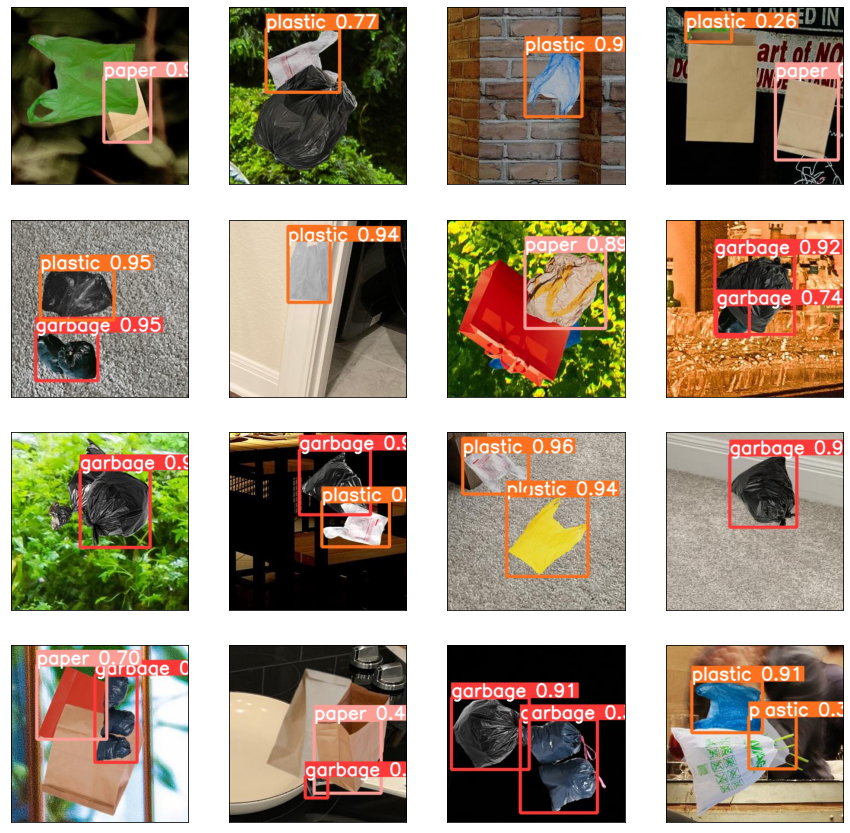

In [ ]:
detections_dir = "runs/detect/yolo_bag_det/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    random_detection_image = PIL.Image.open(random.choice(detection_images))
    ax.imshow(random_detection_image)

In [28]:
!sudo apt-get update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [1,038 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:

In [29]:
import cv2
!export DISPLAY=:1.0
!apt-get install -y xvfb # Install X Virtual Frame Buffer
import os
os.system('Xvfb :1 -screen 0 1600x1200x16  &')    # create virtual display with size 1600x1200 and 16 bit color. Color can be changed to 24 or 8
os.environ['DISPLAY']=':1.0'    # tell X clients to use our virtual DISPLAY :1.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  xserver-common
Recommended packages:
  xfonts-base
The following NEW packages will be installed:
  xvfb
The following packages will be upgraded:
  xserver-common
1 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 812 kB of archives.
After this operation, 2,271 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 xserver-common all 2:1.19.6-1ubuntu4.12 [27.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.12 [785 kB]
Fetched 812 kB in 1s (572 kB/s)
(Reading database ... 123991 files and directories currently installed.)
Preparing to unpack .../xserver-common_2%3a1.19.6-1ubunt

In [30]:
!python detect.py --source /content/UK-Recycling.mp4 --weights runs/train/yolo_bag_det/weights/best.pt --conf 0.50 --view-img

Streaming output truncated to the last 5000 lines.
video 1/1 (2149/7146) /content/UK-Recycling.mp4: 384x640 1 paper, 20.4ms
video 1/1 (2150/7146) /content/UK-Recycling.mp4: 384x640 (no detections), 20.5ms
video 1/1 (2151/7146) /content/UK-Recycling.mp4: 384x640 (no detections), 20.6ms
video 1/1 (2152/7146) /content/UK-Recycling.mp4: 384x640 1 paper, 20.8ms
video 1/1 (2153/7146) /content/UK-Recycling.mp4: 384x640 1 paper, 20.4ms
video 1/1 (2154/7146) /content/UK-Recycling.mp4: 384x640 (no detections), 20.6ms
video 1/1 (2155/7146) /content/UK-Recycling.mp4: 384x640 (no detections), 20.7ms
video 1/1 (2156/7146) /content/UK-Recycling.mp4: 384x640 (no detections), 20.8ms
video 1/1 (2157/7146) /content/UK-Recycling.mp4: 384x640 (no detections), 20.6ms
video 1/1 (2158/7146) /content/UK-Recycling.mp4: 384x640 (no detections), 20.9ms
video 1/1 (2159/7146) /content/UK-Recycling.mp4: 384x640 (no detections), 20.9ms
video 1/1 (2160/7146) /content/UK-Recycling.mp4: 384x640 1 paper, 20.8ms
video 1/1

In [ ]:
!python detect.py --source ./test_image.jpg --weights runs/train/yolo_bag_det/weights/best.pt --conf 0.50 --name yolo_bag_det 

detect: weights=['runs/train/yolo_bag_det/weights/best.pt'], source=./test_image.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_bag_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-267-gbe348cc Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (A100-SXM4-40GB, 40536MiB)

Fusing layers... 
Traceback (most recent call last):
  File "detect.py", line 259, in <module>
    main(opt)
  File "detect.py", line 254, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "detect.py", line 96, in run
    model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data

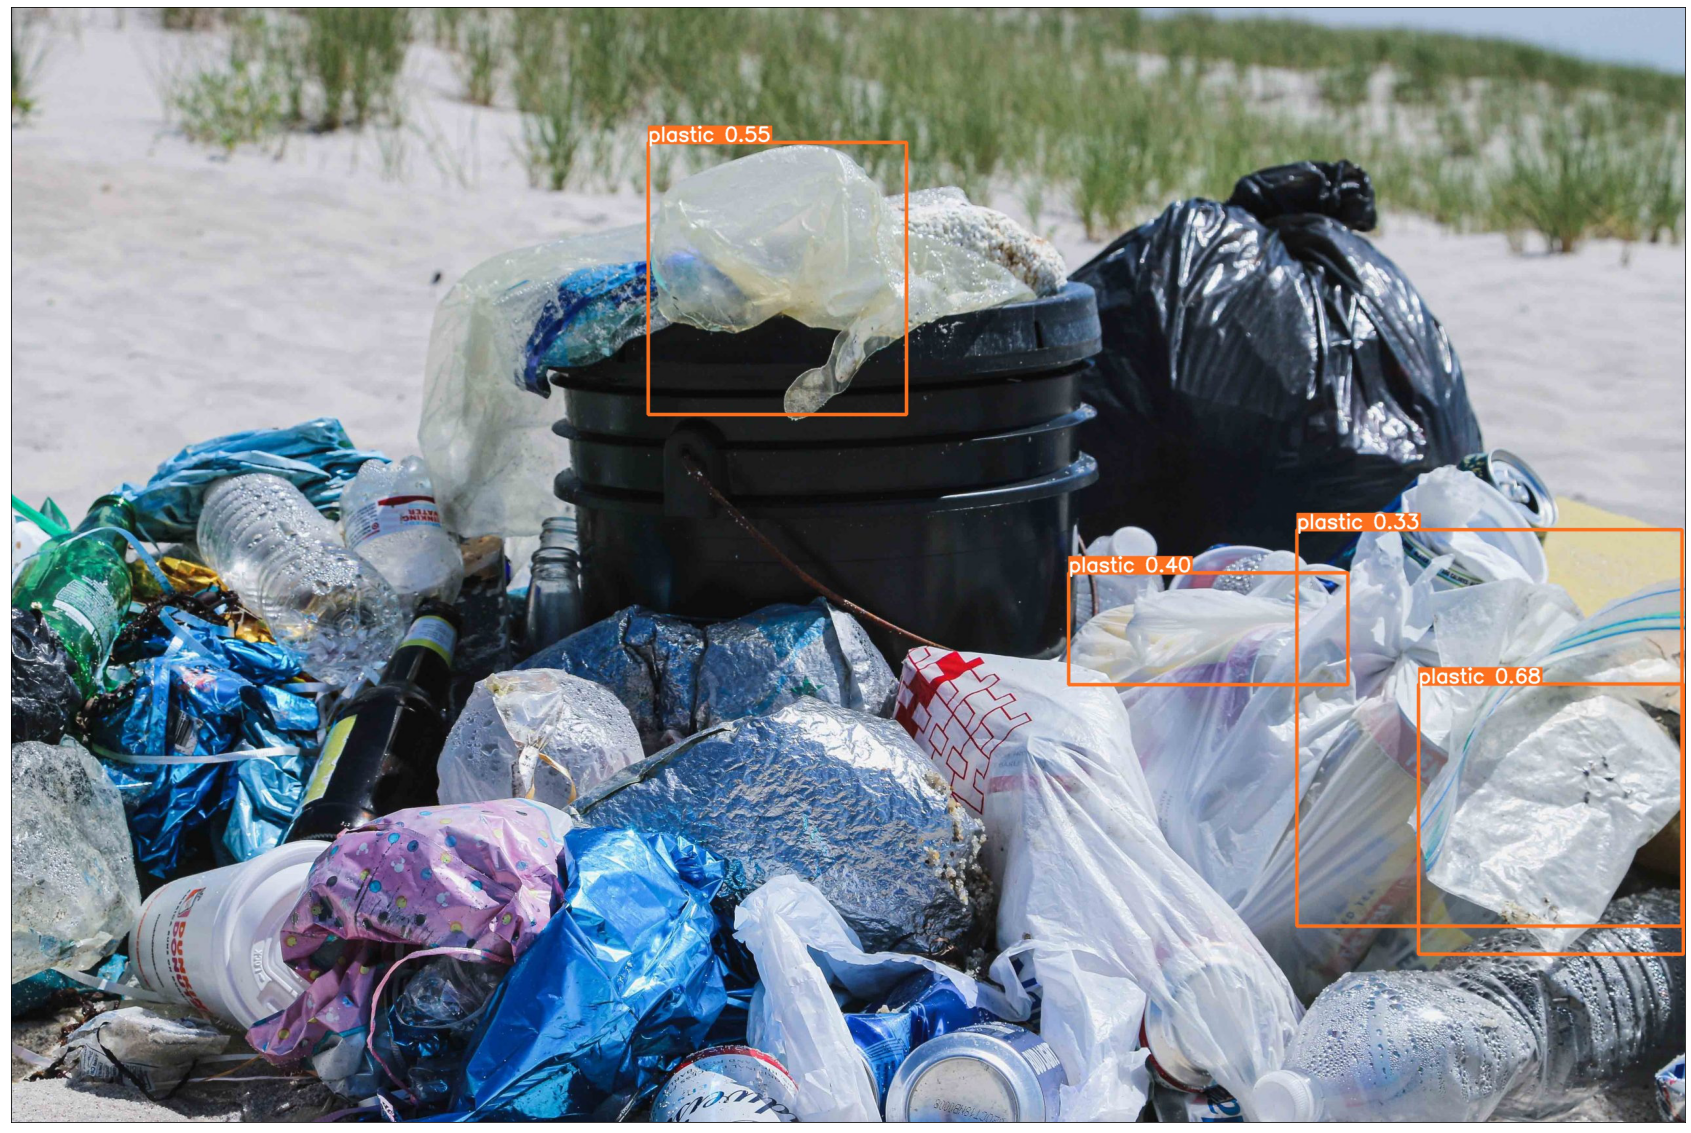

In [ ]:
detections_dir = "runs/detect/yolo_bag_det2/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]
random_detection_image = PIL.Image.open(random.choice(detection_images))
plt.figure(figsize=(30,30));
plt.imshow(random_detection_image)
plt.xticks([])
plt.yticks([]);

In [ ]:
shutil.move("/content/test_image2.JPG", "./yolov5")

'./yolov5'

In [ ]:
# Change the current directory inisde the yolov5
%cd ./yolov5

[Errno 20] Not a directory: './yolov5'
/content/yolov5


In [ ]:
!python detect.py --source ./test_image2.JPG --weights runs/train/yolo_bag_det/weights/best.pt --conf 0.25 --name yolo_bag_det

detect: weights=['runs/train/yolo_bag_det/weights/best.pt'], source=./test_image2.JPG, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_bag_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-189-g2f1eb21 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (A100-SXM4-40GB, 40536MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/yolov5/test_image2.JPG: 352x640 (no detections), 16.0ms
Speed: 0.4ms pre-process, 16.0ms inference, 0.4ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/yolo_bag_det9


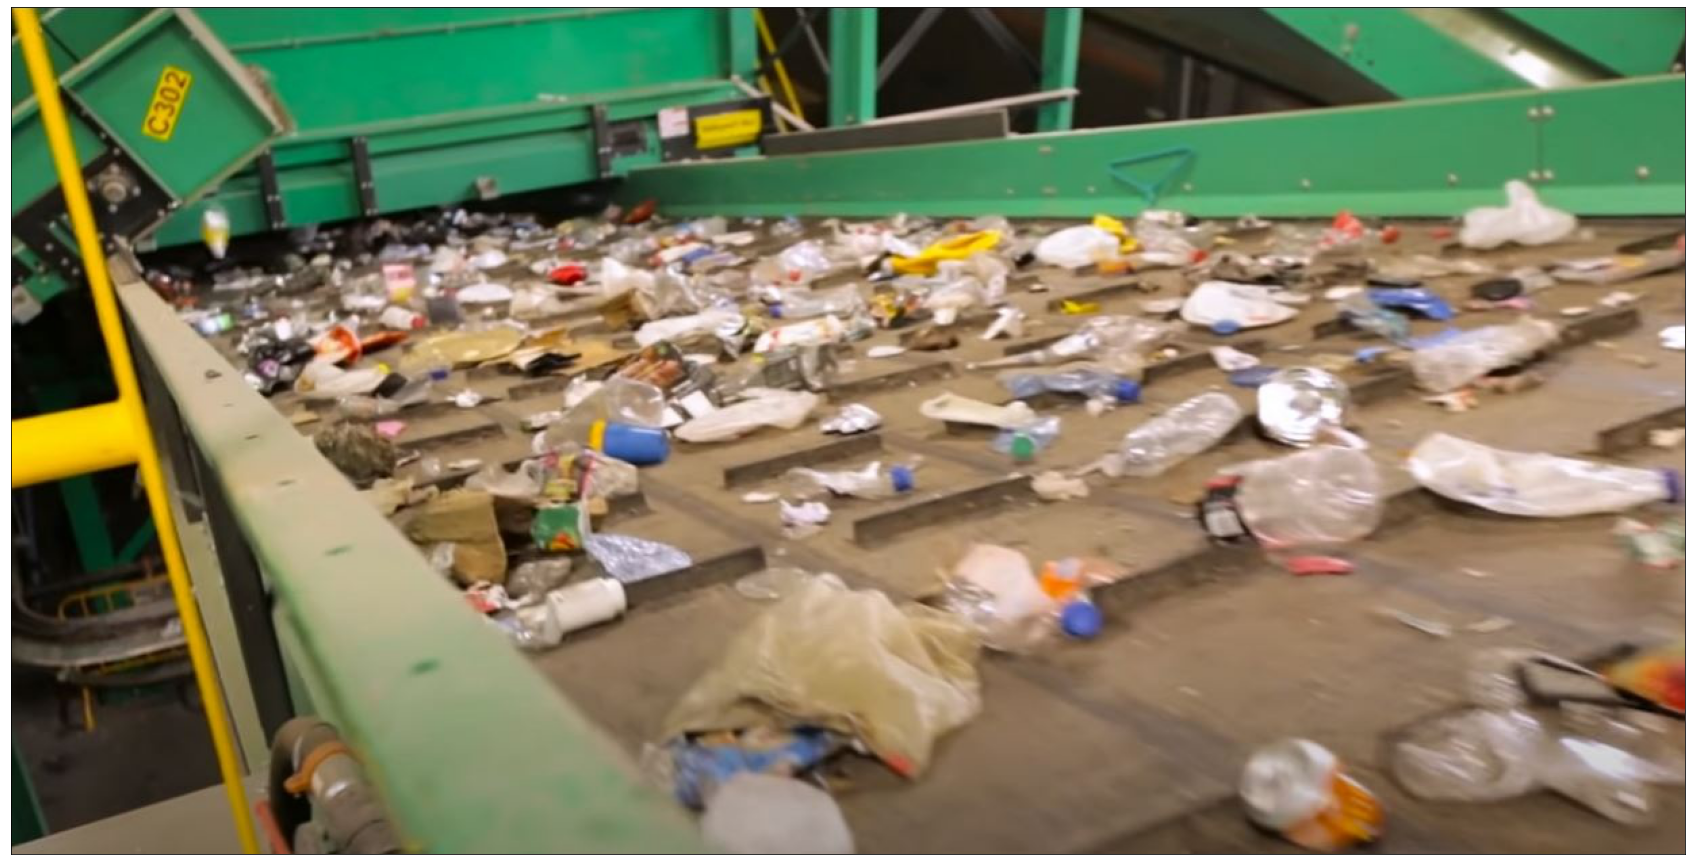

In [ ]:
detections_dir = "runs/detect/yolo_bag_det9/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]
random_detection_image = PIL.Image.open(random.choice(detection_images))
plt.figure(figsize=(30,30));
plt.imshow(random_detection_image)
plt.xticks([])
plt.yticks([]);

In [ ]:
!python detect.py --source ./test_image3.jpg --weights runs/train/yolo_bag_det/weights/best.pt --conf 0.25 --name yolo_bag_det

detect: weights=['runs/train/yolo_bag_det/weights/best.pt'], source=./test_image3.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_bag_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-189-g2f1eb21 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (A100-SXM4-40GB, 40536MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/yolov5/test_image3.jpg: 448x640 (no detections), 16.4ms
Speed: 0.5ms pre-process, 16.4ms inference, 0.4ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/yolo_bag_det11


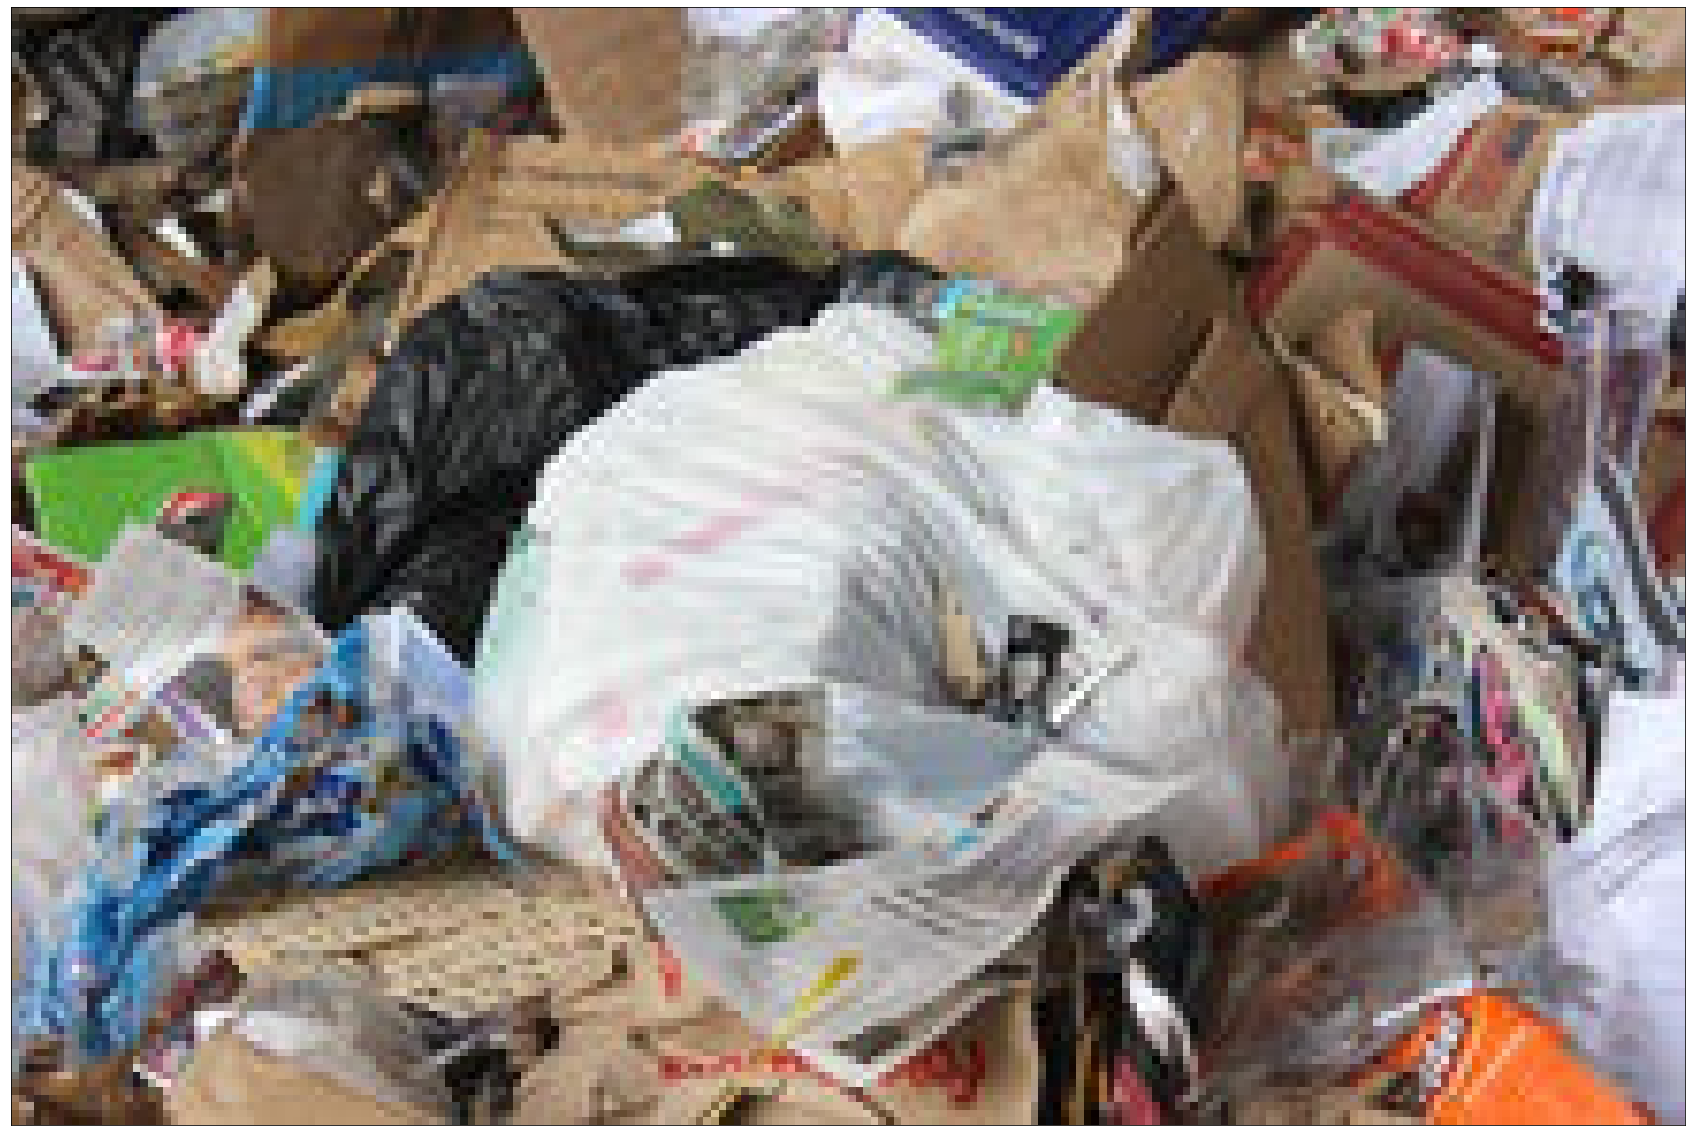

In [ ]:
detections_dir = "runs/detect/yolo_bag_det11/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]
random_detection_image = PIL.Image.open(random.choice(detection_images))
plt.figure(figsize=(30,30));
plt.imshow(random_detection_image)
plt.xticks([])
plt.yticks([]);